In [ ]:
!pip install giotto-tda

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gtda.images  
import gtda.homology
import gtda.diagrams
import cv2 as cv
import tensorflow as tf
import skimage.exposure

In [ ]:
!unzip "/content/drive/MyDrive/American Sign Language - Dataset/sign_mnist_test.csv.zip"
!unzip "/content/drive/MyDrive/American Sign Language - Dataset/sign_mnist_train.csv.zip"

Archive:  /content/drive/MyDrive/American Sign Language - Dataset/sign_mnist_test.csv.zip
  inflating: sign_mnist_test.csv     
Archive:  /content/drive/MyDrive/American Sign Language - Dataset/sign_mnist_train.csv.zip
  inflating: sign_mnist_train.csv    


In [ ]:
from skimage.morphology import skeletonize

In [ ]:
test = pd.read_csv("sign_mnist_test.csv")
train = pd.read_csv("sign_mnist_train.csv")
y = pd.concat([train['label'], test['label']])
train_size = train.shape[0]
test_size = test.shape[0]

In [ ]:
train_images = []
test_images = []
train = np.array(train.iloc[:,1:])
test = np.array(test.iloc[:,1:])

for i in range(0,train_size):
  img_ravelled = train[i]
  train_images.append(np.reshape(img_ravelled,(28,28)))

for i in range(0,test_size):
  img_ravelled = train[i]
  test_images.append(np.reshape(img_ravelled,(28,28)))

train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
size = train_size + test_size
images = np.concatenate((train_images,test_images), axis = 0)

conjugate_images = np.zeros((size,28,28))
for i in range(0,size):
  conjugate_images[i,:,:] =  255 - images[i,:,:]

In [ ]:
#%%plots image_dim*image_dim np array
def plot_image(Q):
    plt.matshow(Q);
    plt.colorbar()

In [ ]:
boundary_matrix = [[(i>1)*(j>1)*(i<26)*(j<26)*1 for i in range(0,28)] for j in range(0,28)]
image_dim = 28

Printing first 5 images


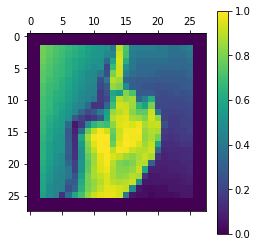

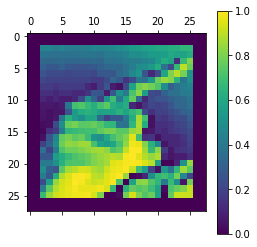

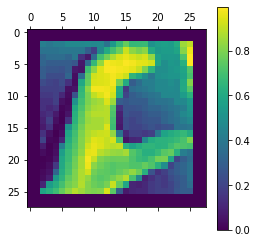

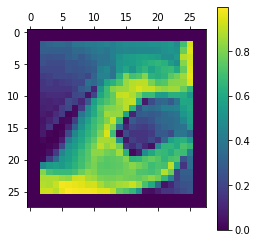

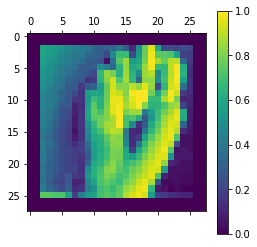

In [ ]:
print('Printing first 5 images')
for i in range(0,5):
  im = skimage.exposure.equalize_hist(conjugate_images[i])
  plot_image(np.multiply(im, boundary_matrix))

In [ ]:
from skimage.filters import threshold_otsu, threshold_local

In [ ]:
binarized_images = np.zeros((size,28,28))
for i in range(0,size):
  global_thresh = threshold_otsu(conjugate_images[i])
  bin_img = images[i] > global_thresh
  binarized_images[i] = bin_img

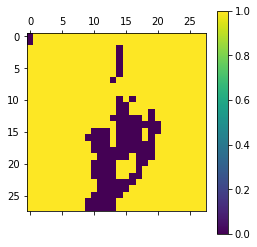

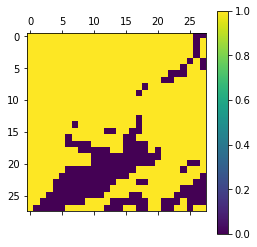

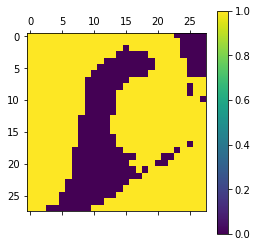

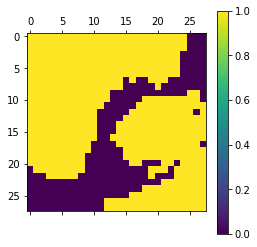

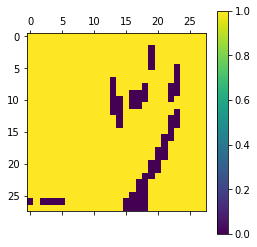

In [ ]:
for i in range(0,5):
  plot_image(binarized_images[i])

In [ ]:
height_array = [[1,0],[0,1],[1,1],[-1,1],[1,-1],[-1,-1],[-1,0],[0,-1]]

def height_data_fn(images = binarized_images, ht_array = height_array, ent=True, land=False, 
                   heat=False, wdist=False, betti=False):
    height_data = np.zeros((np.shape(images)[0],1))
    for i in range(0, np.shape(ht_array)[0]):
        height_fil_images = gtda.images.HeightFiltration(direction = np.array(ht_array[i])).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(height_fil_images)
        if ent == True:
            height_data = np.concatenate((height_data,gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)), axis = 1)
        if land == True:
            height_data= np.concatenate((height_data,gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                                             order = None).fit_transform(cubical_diagrams)), axis = 1)
        if heat == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)
        if betti == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)
        if wdist == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)   
    print("done") 
    return height_data[:,1:]

In [ ]:
radial_array = [[6,6],[13,6],[20,6],[6,13],[13,13],[20,13],[6,20],[13,20],[20,20]]

def radial_data_fn(images = binarized_images, r_array = radial_array, ent=True, land=False, 
                   heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(r_array)[0]
    radial_data = np.zeros((np.shape(images)[0],n_col))
    m = 0 #current column counter
    for i in range(0, np.shape(r_array)[0]):
        radial_fil_images = gtda.images.RadialFiltration(center = np.array(r_array[i])).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(radial_fil_images)
        if ent == True:
            radial_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            radial_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2
    print("done")                       
    return radial_data


In [ ]:
density_array = [5,8,11]

def density_data_fn(images = binarized_images, d_array = density_array, ent=True, land=False, 
                    heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(d_array)[0]
    density_data = np.zeros((np.shape(images)[0],n_col))
    m = 0 #current column counter
    for i in range(0, np.shape(d_array)[0]):
        density_fil_images = gtda.images.DensityFiltration(radius = d_array[i]).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(density_fil_images)
        if ent == True:
            density_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            density_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2
    print("done") 
    return density_data

In [ ]:
def grayscale_data_fn(images = images, ent=True, land=False, 
                      heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    grayscale_data = np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(images)
    m=0
    if ent == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        grayscale_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return grayscale_data

In [ ]:
def vr_data_fn(images = binarized_images, ent=True, land=False, 
               heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    vr_data = np.zeros((np.shape(images)[0],n_col))
    point_cloud_data = gtda.images.ImageToPointCloud().fit_transform(images)
    cubical_diagrams = gtda.homology.VietorisRipsPersistence(reduced_homology = False, infinity_values= 28.0).fit_transform(point_cloud_data)
    m=0
    if ent == True:
        vr_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        vr_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2 
    print("done")           
    return vr_data

In [ ]:
def dilation_data(images = binarized_images, ent=True, land=False, 
                  heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    dil_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.DilationFiltration().fit_transform(images))
    m=0
    if ent == True:
        dil_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        dil_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return dil_data

In [ ]:
def erosion_data_fn(images = binarized_images, ent=True, land=False, 
                    heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    erosion_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.ErosionFiltration().fit_transform(images))
    m=0
    if ent == True:
        erosion_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        erosion_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")         
    return erosion_data

In [ ]:
def sd_data_fn(images = binarized_images, ent=True, land=False, 
               heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    sd_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.SignedDistanceFiltration().fit_transform(images))
    m=0
    if ent == True:
        sd_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        sd_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return sd_data

In [ ]:
# ax+by+c denotes line we are considering
def direction_filtration(Q,a,b,c, par = True):
    shape_x = np.shape(Q)[0]
    shape_y = np.shape(Q)[1]
    Qnew = np.zeros((shape_x,shape_y))
    for i in range(0,shape_x):
        for j in range(0,shape_y):
            if par and Q[i][j] == 1:
                Qnew[i][j] = abs(a*i + b*j + c)/((a**2 + b**2)**(1/2))
            if par != True and Q[i][j] == 1:
                Qnew[i][j] = -1 * abs(a*i + b*j + c)/((a**2 + b**2)**(1/2))
    max_val = np.max(Qnew)
    for i in range(0,shape_x):
        for j in range(0,shape_y):
            if Q[i][j] == 0:
                Qnew[i][j] = max_val+5
    return Qnew


In [ ]:
#line filtration corr to a,b,c for line of form ax+by+c = 0

def line_filtration(nparr, coeff, l):
    line_data = np.zeros((np.shape(coeff)[0],np.shape(nparr)[0],image_dim,image_dim))  
    for k in range(0,np.shape(nparr)[0]):
        for t in range(0,np.shape(coeff)[0]):
            line_data[t][k] = direction_filtration(binarized_images[k], a = coeff[t][0]
                                                   ,b = coeff[t][1]
                                                   ,c = coeff[t][2]
                                                   ,par = l[t])
    return line_data


In [ ]:
l = np.array((True, True, False, False))
coeff = [[1,-1,-20],[0,1,-27],[0,1,-13],[1,0,-13]]

def line_data_fn(images = binarized_images, ent=True, land=False, 
                 heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(coeff)[0]
    line_data =  np.zeros((np.shape(images)[0],n_col))
    line_fil_images = line_filtration(images,coeff, l)
    m = 0 #current column counter
    for i in range(0, np.shape(coeff)[0]):
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(line_fil_images[i])
        if ent == True:
            line_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            line_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2     
    print("done") 
    return line_data

In [ ]:
height_data = height_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(height_data).to_csv('height_data.csv')
density_data = density_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(density_data).to_csv('density_data.csv')
radial_data = radial_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(radial_data).to_csv('radial_data.csv')

done
done
done


In [ ]:
line_data = line_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(line_data).to_csv('line_data.csv')
grayscale_data = grayscale_data_fn(images = images, ent = True, wdist = True, land = True, betti = True)
pd.DataFrame(grayscale_data).to_csv('grayscale_data.csv')
conjugate_data = grayscale_data_fn(images = conjugate_images, ent = True, wdist = True, land = True, betti = True)
pd.DataFrame(conjugate_data).to_csv('conjugate_data.csv')
#vr_data = vr_data_fn(images = binarized_images, ent = True)
#pd.DataFrame(vr_data).to_csv('vr_data.csv')

done
done
done


In [ ]:
!zip pipeline_ASL_images_otsu.zip *.csv
!mv pipeline_ASL_images_otsu.zip "/content/drive/MyDrive/American Sign Language - Dataset"

  adding: conjugate_data.csv (deflated 53%)
  adding: density_data.csv (deflated 61%)
  adding: grayscale_data.csv (deflated 53%)
  adding: height_data.csv (deflated 64%)
  adding: line_data.csv (deflated 66%)
  adding: radial_data.csv (deflated 59%)
  adding: sign_mnist_test.csv (deflated 71%)
  adding: sign_mnist_train.csv (deflated 71%)


In [ ]:
height_data = (pd.read_csv("height_data.csv")).iloc[:,1:]
density_data = (pd.read_csv("density_data.csv")).iloc[:,1:]
radial_data = (pd.read_csv("radial_data.csv")).iloc[:,1:]
line_data = (pd.read_csv("line_data.csv")).iloc[:,1:]
grayscale_data = (pd.read_csv("grayscale_data.csv")).iloc[:,1:]
conjugate_data = (pd.read_csv("conjugate_data.csv")).iloc[:,1:]

In [ ]:
data = pd.concat([height_data,density_data,radial_data,line_data,grayscale_data,conjugate_data], axis = 1)

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
data = normalize(data)

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
import sklearn.preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import normalize

In [ ]:
train_data = data[:train_size,]
test_data = data[train_size:,]

In [ ]:
svm_model_linear = SVC(kernel = 'rbf', class_weight = 'balanced', decision_function_shape='ovo').fit(train_data, y.iloc[:train_size]) 
svm_predictions = svm_model_linear.predict(test_data)

4.113218070273285


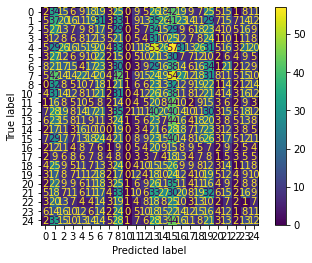

In [ ]:
accuracy = svm_model_linear.score(test_data, y.iloc[train_size:])
print(accuracy*100)
plot_confusion_matrix(svm_model_linear, test_data, y.iloc[train_size:])

In [ ]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 31415)
classifier.fit(train_data, y.iloc[:train_size])

In [ ]:
pred = classifier.predict(test_data)
accuracy = classifier.score(test_data, y.iloc[train_size:])
print(accuracy*100)

4.155047406581149


In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, test_data, y.iloc[train_size:]) 

In [ ]:
#Integrating Data with CNN
from tensorflow import keras
import tensorflow as tf

In [ ]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(test_images.shape)  

(7172, 28, 28, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

num_filters = 8
filter_size = 3
pool_size = 2

model_1 = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(25, activation='softmax'),
])